## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Francesca Palermo, Nan Fletcher-Lloyd, Alex Capstick, Yu Chen
**Spring 2024**



# Probability and Bayesian Theory

This tutorial will focus on probability and Bayesian theory using the machine learning library for Python scikit-learn (https://scikit-learn.org/stable).

## Import Dependencies

In [1]:
import sklearn as sk
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Probability and Statistical Test

In this section, we will introduce you to hypothesis testing. 

Hypothesis testing is a statistical method that is used to make decisions using experimental data. 

A hypothesis is basically an assumption made about a population parameter and a test evaluates two mutually exclusive statements about a population to determine which statement is best supported by the data. 

These statements are the null and alternative hypothesis.

The null hypothesis suggests that no statistical significance exists in a set of given observations.

The alternative hypothesis is contrary to the null hypothesis. It is usually taken to be that the observations are the result of a real effect.

Read more about the key terms of hypothesis testing and the different types and when to use them here: https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

Here, we will demonstrate how, with enough data, statistics can enable us to calculate probabilities using real-world observations. 

Here, probability provides the theory while statistics provides the tools to test that theory using data.

In the end, descriptive statistics such as the mean and standard deviation of the data become proxies for theoretical. This is because real-world probabilities are often quite difficult to calculate. As such, we rely on statistics and data.

With more and more data, we can become more confident that what we calculate represents the true probability of these events occurring.

So let's start with a question. For this, we are going to download the iris dataset.

In [2]:
data = datasets.load_iris(as_frame=True)
features = data.data # this derives features as a dataframe (13 features by 178 instances)
labels = data.target # this derives labels as a dataframe (178 instances)

In [3]:
iris = pd.concat([features, labels], axis=1,)
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Now, a quick check will remind us that there are three classes of iris in this dataset.

In [4]:
labels.unique()

array([0, 1, 2])

For this question, we will compare two of the three different types of iris across one feature variable, removing the need for scaling. 

So, let's pose our question. Is the sepal length different between classes 0 and 1?

First, we select for these classes and the column of interest.

In [5]:
question = iris.iloc[:, [0,-1]] # selects for the feature variable
question

,sepal length (cm),target
0,5.1,0
1,4.9,0
2,4.7,0
3,4.6,0
4,5.0,0
...,...,...
145,6.7,2
146,6.3,2
147,6.5,2
148,6.2,2


Next, we need to group our 'question' dataframe by class. 

A quick check of the data shows that the target is an integer. To split out dataframe by group, we need this to be a str.

In [6]:
question.dtypes

sepal length (cm)    float64
target                 int64
dtype: object

In [7]:
question['target'] = question['target'].astype(str) #converts the target column to str

/tmp/ipykernel_38314/397028055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question['target'] = question['target'].astype(str) #converts the target column to str


In [8]:
question.dtypes

sepal length (cm)    float64
target                object
dtype: object

We now want to use these values of the sepal length of the two different classes of iris to compare groups but these scores fall in a range. So how do we compare groups of values between types of iris and know with some degree of certainty that one is different from the other?

For this, we first need to understand the distribution of these data.

So let's visualise each group of values as histograms.

Learn more about using histograms here: https://seaborn.pydata.org/generated/seaborn.histplot.html

In [9]:
class_0 = iris.loc[labels==0]
class_1 = iris.loc[labels==1]

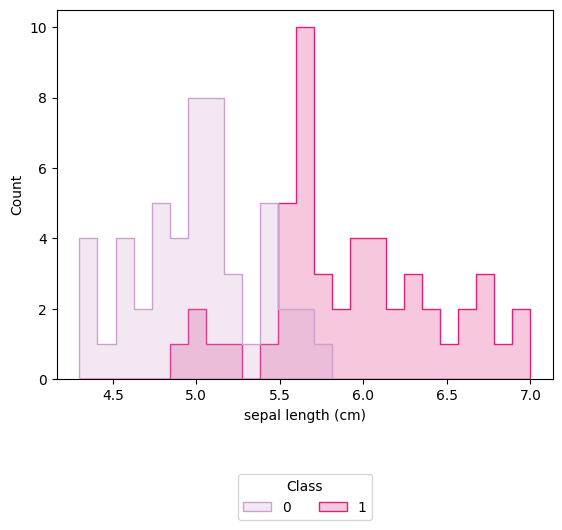

In [10]:
df = pd.concat([class_0, class_1])
ax = sns.histplot(data=df, x=iris.columns[0], hue="target", element="step", bins=25, palette='PuRd')
sns.move_legend(ax, title='Class',loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)


Here we see that the data in each class is approximately normally distributed.

In probability, the normal distribution is a particular distribution of the probability across all of the data. The x-axis takes on the values of the data and the y-axis is the probability associated with each datapoint, from 0 to 1.

The high point of the distribution represents the datapoint with the highest probability of occurring. As you move further away from this point on either side, the probability of those points decreases, forming the familiar bell-shape curve. The high point in a statistical context actually represents the mean, and as you move farther from the mean, frequency rapidly decreases.

If any two distributions overlap significantly, we might assume they actually come from the same distribution and that there is no real difference in the means of those dsitributions. If there is no overlap, it is safe to assume that the distributions aren't the same. But, as you will see in the plot above, the difficulty is when there is some overlap.

The normal distribution is significant to probability and statistics due to two factors: the Central Limit Theorem and the Three Sigma Rule.

The key tenet of the Central Limit Theorem is that with more data, the closer the average of these data to the true probability. The Central Limit Theorem dictates that if we collect many data, the distribution of these data will look like a normal distribution and the high point of this distribution will align with the true value that the estimates should take on, i.e. the average of these many data will approach the true mean.

The Three Sigma Rule tells us how much the data will be spread out aroud this mean or how many of the data falls within a certain distance of the mean. The standard deviation is the average distance a singular measurement in the dataset is from the mean. The Three Sigma Rule dictates that given a normal distribution, 68% of the measurements will fall between one standard deviation of the mean, 95% within two, and 99.7% within three. This rule is also a statement of rarity of extreme values.

By taking advantage of the Three Sigma Rule, we can prescribe a value to how likely it is that the the sepal length is different within each class of iris.

Now, the next thing we want to do is turn our question into a null and alternative hypothesis, as this will allows us to carry out hypothesis testing.

Question: Is the sepal length different between classes 0 and 1?

So, our null hypothesis is that the sepal length is no different between classes 0 and 1 and our alternative hypothesis is that the sepal length is different between classes 0 and 1.

If you read through the article from earlier (https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce) you will know that there are several different types of statistical tests that can be conducted to test a hypothesis.

Here, we want to test whether the means of two independent groups are equal or not. As such, we know we will be conducting a two sample, two-tailed test.

We are assuming that our data is normally distributed but we also know that the sample size of each group is greater than 30 so this does not matter quite so much. It is also possible to calculate the mean and standard deviation of both sample groups. Given this, we are going to run a z-test.

First, let's calculate the mean and standard deviation of the sepal length of each class of iris.

In [11]:
col = df.columns[0]
print(col+" in two classes")
print("Class 0:  mean {}, std {}".format(class_0[col].mean().round(3), class_0[col].std().round(3)))
print("Class 1:  mean {}, std {}".format(class_1[col].mean().round(3), class_1[col].std().round(3)))

sepal length (cm) in two classes
Class 0:  mean 5.006, std 0.352
Class 1:  mean 5.936, std 0.516


These values look very similar! But let's calculate the z-test statistic before making any final decisions.

In [12]:
from statsmodels.stats.weightstats import ztest

*N.B. you can learn more about using the statsmodels z-test here: https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html*

This method requires the dataframes to be in arrays.

In [13]:
class_0 = class_0[col].values
class_1 = class_1[col].values

Finally, we can calculate the test-statistic and p-value.

In [14]:
ztest(class_0, class_1, value=0, alternative='two-sided') 

(-10.52098626754911, 6.914595261207391e-26)

The p-value tells us whether to accept or reject the null hypothesis. 100% accuracy is not possible for accepting or rejecting a hypothesis; therefore, we select a level of significance that is usually 5%. As such, if the p-value > 0.05, then the null hypothesis is accepted, but if the p-value < 0.05, then the null hypothesis is rejected.

In this case, we reject the null hypothesis. The sepal length is different between classes 0 and 1.

And that's it! You've now learnt the basics of hypothesis testing.

## Bayesian Theory

The second part of this tutorial will focus on Bayesian theory.

Now, as you will have learnt in your lectures, Naive Bayes methods are a set of supervised learning methods (classifiers) that assume that the presence of a particular feature in a class is unrelated to the presence of any other feature.

There are several types of Naive Bayes models (learn more here: https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) but for this exercise, we will focus on Gaussian Naive Bayes classifiers.

Learn more about how to use a Gaussian Naive Bayes classifier here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB

For this, we will create our own dataset of 10 features across 500 instances, categorised into two classes. Class 0 represents a control group and Class 1 the class of interest. As in real world medical problems, there are fewer isntances of the class of interest.

Learn more about making your own classification datasets here: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [15]:
features, labels = datasets.make_classification(n_samples=500, n_features=10, n_informative=8, n_classes=2, weights=np.array([0.65, 0.35]), flip_y=0.01, class_sep=2.0, shuffle=True, random_state=42)

Now, let's take a quick look at the features and labels that were generated, in dataframe form for ease.

In [16]:
features = pd.DataFrame(features)
labels = pd.DataFrame(labels)
df = pd.concat([features, labels], axis=1)
df.columns = ["F"+str(i) for i in range(10)] + ['Class']
df

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,Class
0,2.899136,-1.504262,-2.865578,3.189817,1.734764,2.105161,-3.229556,2.403973,-2.902707,0.499130,0
1,3.467613,-4.406937,2.849073,1.153019,2.711802,-1.961105,-2.671268,1.039823,-1.566765,-0.077519,1
2,3.644711,-0.110035,6.222994,-2.802069,-2.520034,2.023644,0.552524,1.413821,-1.214413,-2.570579,0
3,6.766245,-1.878676,-2.187759,9.928311,1.398671,-1.391950,-5.457044,-0.512490,-1.123277,1.302933,0
4,0.310887,-2.485219,2.607958,-1.757280,1.853096,-0.287983,-1.154815,1.309090,-2.093734,2.235665,1
...,...,...,...,...,...,...,...,...,...,...,...
495,0.218707,0.491198,-1.439844,-1.414677,1.648513,3.248171,-2.144993,3.165031,-1.861948,0.788817,0
496,4.153598,-0.616152,1.543311,0.248600,-1.944762,0.097494,2.932468,-0.694211,-1.438984,-0.710786,0
497,-2.801126,-4.375751,-2.436777,5.271192,-1.857045,-4.107250,-2.672585,1.632947,-2.407046,2.527889,1
498,2.770104,-1.092493,0.798509,1.294682,4.686547,-2.308703,-3.820610,0.356281,1.419128,1.836637,1


Now, as we are working with Naive Bayes classifer, we do not need to do any feature scaling, so let's get straight into building our model. 

First, we must split our data into training and testing data.

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state = 42)

Next, we need to import and build our model.

In [18]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB(var_smoothing=0.5)

In [19]:
GNB.fit(x_train, y_train) # fits the model on the training data
y_pred = GNB.predict(x_test) # predicts labels on the test data
y_pred_probs = GNB.predict_proba(x_test) # predicted probability of each class on the test data

/home/alexcapstick/anaconda3/envs/ml4ns/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now, we want to evaluate the performance of the classification model.

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [21]:
f1 = f1_score(y_test, y_pred,average=None)
recall = recall_score(y_test, y_pred,average=None)
precision = precision_score(y_test, y_pred,average=None)


print('\nf1:\t\t',f1)
print('recall\t\t',recall)
print('precision\t',precision)

print('\nf1_avg:\t\t',f1.mean())
print('recall_avg\t',recall.mean())
print('precision_avg\t',precision.mean())

print('\nf1_sd:\t\t',f1.std())
print('recall_sd\t',recall.std())
print('precision_sd\t',precision.std())

print('\n',classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_probs[:,1]))


f1:		 [0.87671233 0.66666667]
recall		 [0.98461538 0.51428571]
precision	 [0.79012346 0.94736842]

f1_avg:		 0.7716894977168949
recall_avg	 0.7494505494505495
precision_avg	 0.8687459389213774

f1_sd:		 0.1050228310502283
recall_sd	 0.23516483516483522
precision_sd	 0.07862248213125406

               precision    recall  f1-score   support

           0       0.79      0.98      0.88        65
           1       0.95      0.51      0.67        35

    accuracy                           0.82       100
   macro avg       0.87      0.75      0.77       100
weighted avg       0.85      0.82      0.80       100

0.9516483516483516


Now, these scores are not very good, particularly when it comes to identifying the class of interest (Class 1). So how can we improve model performance?

Well, one method is to tune the hyperparameters of the model (read more about this here: https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba)

For this, we first need to import the sklearn GridSearchCV function. This functions runs through all the different parameters fed into the parameter grid and produces the best combination of parameters based on a chosen scoring metric.

Learn more about how to use this function here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [22]:
from sklearn.model_selection import GridSearchCV

Next, we need to set the range of all the parameters we will feed into the parameter grid. For a Gaussian Naive Bayes classifier, this is just var_smoothing, which represents a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean.

In [23]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=1000)} # np.logspace returns numbers spaced evenly on a log scale, starts from 0, ends at -9, and generates 1000 samples

Now, we build the GridSearchCV, using the model and parameter grid. We then fit this searching tool to the training data using a 10-fold cross-validation to find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results.

In [24]:
GNB_Grid = GridSearchCV(estimator=GaussianNB(var_smoothing=0.5), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
GNB_Grid.fit(x_train, y_train.values.reshape(-1))

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10, estimator=GaussianNB(var_smoothing=0.5), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 9.79469667e-01, 9.59360829e-01, 9.39664831e-01,
       9.20373200e-01, 9.01477631e-01, 8.82969996e-01, 8.64842328e-01,
       8.47086827e-01, 8.29695852e-01, 8.12661920e-01, 7.95977700e-01,
       7.79636013e-01, 7.63629826e-01, 7.47952252e-01, 7.32596543e-01,
       7.1755...
       1.61141428e-09, 1.57833141e-09, 1.54592774e-09, 1.51418933e-09,
       1.48310251e-09, 1.45265393e-09, 1.42283046e-09, 1.39361927e-09,
       1.36500781e-09, 1.33698374e-09, 1.30953502e-09, 1.28264983e-09,
       1.25631660e-09, 1.23052400e-09, 1.20526094e-09, 1.18051653e-09,
       1.15628013e-09, 1.13254132e-09, 1.10928986e-09, 1.08651577e-09,
       1.06420924e-09, 1.04236067e-09, 1.02096066e-09, 1.00000000e-09])},
             verbose=1)

In [25]:
print(GNB_Grid.best_estimator_)

GaussianNB(var_smoothing=0.12305240043592616)


Now we want to re-evaluate the model on the test data.

In [26]:
grid_pred = GNB_Grid.predict(x_test)
grid_pred_probs = GNB_Grid.predict_proba(x_test) # predicted probability of each class on the test data

In [27]:
f1 = f1_score(y_test, grid_pred,average=None)
recall = recall_score(y_test, grid_pred,average=None)
precision = precision_score(y_test, grid_pred,average=None)


print('\nf1:\t\t',f1)
print('recall\t\t',recall)
print('precision\t',precision)

print('\nf1_avg:\t\t',f1.mean())
print('recall_avg\t',recall.mean())
print('precision_avg\t',precision.mean())

print('\nf1_sd:\t\t',f1.std())
print('recall_sd\t',recall.std())
print('precision_sd\t',precision.std())

print('\n',classification_report(y_test, y_pred))
print(roc_auc_score(y_test, grid_pred_probs[:,1]))


f1:		 [0.89552239 0.78787879]
recall		 [0.92307692 0.74285714]
precision	 [0.86956522 0.83870968]

f1_avg:		 0.8417005879692447
recall_avg	 0.832967032967033
precision_avg	 0.8541374474053296

f1_sd:		 0.05382180009045673
recall_sd	 0.09010989010989012
precision_sd	 0.015427769985974726

               precision    recall  f1-score   support

           0       0.79      0.98      0.88        65
           1       0.95      0.51      0.67        35

    accuracy                           0.82       100
   macro avg       0.87      0.75      0.77       100
weighted avg       0.85      0.82      0.80       100

0.9665934065934065


Now, these scores are much better!

And there you have it! You've now built and tuned your first Bayesian classifer.

Now you've finished this tutorial, follow the instructions and complete the assessment.